In [1]:
import sys
import pandas as pd
import numpy as np
from numpy import mean
import time
import imdb
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.stats import pearsonr
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import re

#function that uses a regex to extract data we need from various cols in dataset
def extractData(str):
    return re.findall("'name': \'(.+?)\'", str)

In [3]:
#function to get past movie success
def calcPastSuccess(movie, ia):
    start_time = time.time()
    for i in range(8):
        actor = movie['cast'][i]
        filmList = ia.get_person_filmography(actor.getID())['data']['filmography'][0]
        filmography = filmList.get('actor')
        if filmography is None:
            filmography = filmList.get('actress')

        totalRating = 0
        totalBO = 0
        movieCount = 0
        accMovieCount = 0
        for film in filmography:
            if film['kind'] == 'movie':
                film = ia.get_movie(film.getID())
                rating = film.get("rating")
                boxOffice = film.get("box office")
                if boxOffice is not None :
                    gross = boxOffice.get('Cumulative Worldwide Gross')
                else:
                    gross = None

                accMovieCount += 1
                if rating is not None and gross is not None:
                    totalRating += float(rating)
                    gross = gross.split(' ')[0][1:].replace(',','')
                    totalBO += float(gross)
                    movieCount += 1
        if movieCount > 0:
            AvgIMDbScore = totalRating/movieCount
            AvgBO = totalBO/movieCount
        else:
            AvgIMDbScore = 0
            AvgBO = 0
        print("Statistics for", actor)
        print('Number of Movies used in formula: ',movieCount)
        print('Number of Movies Total: ', accMovieCount)
        print("Average IMDb Score: ", AvgIMDbScore)
        pastIMDbFormula = AvgIMDbScore - 10 * (1/3)**movieCount
        pastBoxOfficeFormula = 10* (AvgBO / 100000000) - 10 * (1/3)**movieCount

        print('IMDb Weighted Average Rating for: ', pastIMDbFormula)
        print('Box Office Weighted Average for: ', pastBoxOfficeFormula)
        print("--- %s minutes ---" % ((time.time() - start_time)/60))
        print()

# Features

belongs_to_collection

genres

original_title (na)

popularity

production_companies

release_date

spoken_languages

tagline (na)

keywords (na)

crew

# Loading Data & Preliminary

In [97]:
#Load in the data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
#Look at all of the columns
print(train.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')


In [98]:
#Drop columns we will not be using and inspect the head of train
train = train.drop(columns=[ 'homepage', 'poster_path', 'original_title', 'overview','tagline','Keywords'])
train.head(5)
test = test.drop(columns=[ 'homepage', 'poster_path', 'original_title', 'overview','tagline','Keywords'])
test.head(5)

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,title,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",tt1226251,ja,3.851534,NaN,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Pokémon: The Rise of Darkrai,"[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",tt0051380,en,3.559789,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Attack of the 50 Foot Woman,"[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",tt0118556,en,8.085194,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Addicted to Love,"[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",tt1255953,fr,8.596012,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,Incendies,"[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",tt0418753,en,3.217680,NaN,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Inside Deep Throat,"[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [99]:
print(train.shape)
print(test.shape)

(3000, 17)
(4398, 16)


In [7]:
print(train.describe())

                id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09


In [100]:
#replace all NA values to empty strings so we can extract data cleanly
train.genres = train.genres.fillna("")
train.production_companies = train.production_companies.fillna("")
train.production_countries = train.production_countries.fillna("")
train.spoken_languages = train.spoken_languages.fillna("")

test.genres = test.genres.fillna("")
test.production_companies = test.production_companies.fillna("")
test.production_countries = test.production_countries.fillna("")
test.spoken_languages = test.spoken_languages.fillna("")

In [101]:
#use helper function to extract data from necessary features
train['genres_reform'] = train['genres'].apply(lambda x: extractData(x))
train['production_companies_reform'] = train['production_companies'].apply(lambda x: extractData(x))
train['production_countries_reform'] = train['production_countries'].apply(lambda x: extractData(x))
train['spoken_languages_reform'] = train['spoken_languages'].apply(lambda x: extractData(x))

test['genres_reform'] = test['genres'].apply(lambda x: extractData(x))
test['production_companies_reform'] = test['production_companies'].apply(lambda x: extractData(x))
test['production_countries_reform'] = test['production_countries'].apply(lambda x: extractData(x))
test['spoken_languages_reform'] = test['spoken_languages'].apply(lambda x: extractData(x))

In [102]:
train.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,spoken_languages,status,title,cast,crew,revenue,genres_reform,production_companies_reform,production_countries_reform,spoken_languages_reform
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,[Comedy],"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],[English]
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,"[Comedy, Drama, Family, Romance]",[Walt Disney Pictures],[United States of America],[English]
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,[Drama],"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],[English]
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,"[Thriller, Drama]",[],[India],"[English, हिन्दी]"
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,"[Action, Thriller]",[],[South Korea],[한국어/조선말]


In [103]:
# you can easily index through it now, like so:
print(train['genres_reform'][1])
for genre in train['genres_reform'][1]:
    print(genre)

['Comedy', 'Drama', 'Family', 'Romance']
Comedy
Drama
Family
Romance


In [104]:
# Will likely make this another separate file as a helper function, can be used for several of the features
def unpackCol(list, train):
    for i in range(len(train)):
        for name in list[i]:
            if name not in train.columns:
                train[name] = 0
            train[name][i] = 1
    return train

In [105]:
# stripping the 'tt' from the idmb id, only used in url and easier to get movies without it
train['imdb_id'] = train['imdb_id'].str[2:]
train['imdb_id']

0       2637294
1       0368933
2       2582802
3       1821480
4       1380152
         ...   
2995    0109403
2996    2364975
2997    0116908
2998    0343135
2999    1600195
Name: imdb_id, Length: 3000, dtype: object

# Belongs to Collection

In [106]:
# here is a quick line to sort out the collection stuff
train.belongs_to_collection = train.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)
test.belongs_to_collection = test.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [107]:
print(train.belongs_to_collection)
print()
print('Total movies in collections:', sum(train.belongs_to_collection))
print('Total movies not in collections:', (train.belongs_to_collection == 0).sum(axis=0))

0       1
1       1
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: belongs_to_collection, Length: 3000, dtype: int64

Total movies in collections: 604
Total movies not in collections: 2396


### Univariate Analysis

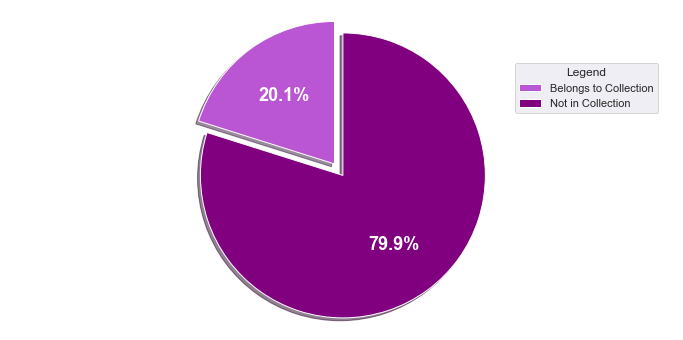

In [108]:
# plotting belongs to collection data
labels = 'Belongs to Collection', 'Not in Collection'
btc_1 = [sum(train.belongs_to_collection), (train.belongs_to_collection == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['mediumorchid', 'purple']

# plot
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 18, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          bbox_to_anchor=(0.75, 0.25, 0.5, 1))

From a total of 3000 data points, 604 or 20.1% were a part of a collection of films, while the other 2396 or 79.9% were not. Belonging to a collection has the potential to be an important feature when predicting revenue as customers may be more likely to pay for a movie-going experience when it is the next iteration of a series into which they have already invested time and money. The origin of serial media is largely accredited to The Pickwick Papers, written by Charles Dickens in 1836, and has since boomed all the way into the 21st century. Given the current and historic popularity of the format, it is hypothesized that belonging to a collection will indicate a positive correlation with revenue.

In [110]:
train.isna().sum()
test.isna().sum()

id                              0
belongs_to_collection           0
budget                          0
genres                          0
imdb_id                         0
original_language               0
popularity                      0
production_companies            0
production_countries            0
release_date                    1
runtime                         4
spoken_languages                0
status                          2
title                           3
cast                           13
crew                           22
genres_reform                   0
production_companies_reform     0
production_countries_reform     0
spoken_languages_reform         0
dtype: int64

### Bivariate Analysis

Not in Collection        2396
Belongs in Collection     604
Name: has_collection, dtype: int64


Text(0.5, 0, 'Collection Status')

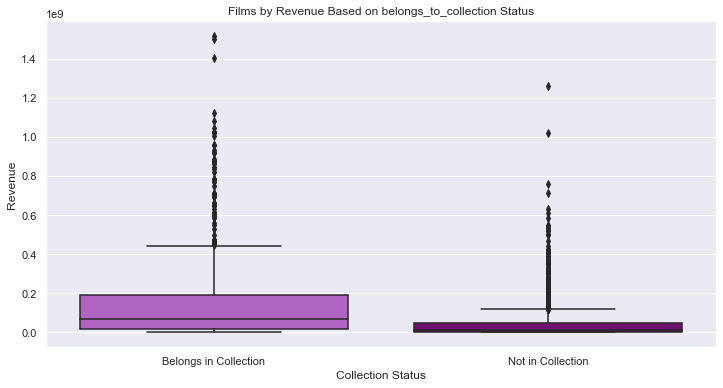

In [18]:
# bivariate analysis of revenue with belongs_to_collection
train['has_collection'] = train['belongs_to_collection'].apply(lambda x: 'Belongs in Collection' if x == 1 else 'Not in Collection')
print(train['has_collection'].value_counts())

pal1 = ['mediumorchid', 'purple']

sns.set(rc={'figure.figsize':(12, 6)})
sns.boxplot(x='has_collection', y='revenue', data=train, palette=pal1)
plt.title('Films by Revenue Based on belongs_to_collection Status')
plt.ylabel("Revenue")
plt.xlabel("Collection Status")

The graph above supports the hypothesis that belonging to a collection enhances a film's revenue in a positive correlation. More work could be done to quantify the precise benefit associated with a film's status as 'Belongs in Collection.'

In [19]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['belongs_to_collection'], train['revenue'])
print('Pearsons correlation between belongs_to_collection and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['belongs_to_collection']), np.log1p(train['revenue']))
print('Pearsons correlation between belongs_to_collection and revenue: %.3f' % corr)

Pearsons correlation between belongs_to_collection and revenue: 0.339
Pearsons correlation between belongs_to_collection and revenue: 0.257


# Genres

In [20]:
# example of using it to unpack the genres 
train = unpackCol(train['genres_reform'], train)

In [21]:
# here's what it did
print(train.columns)
print()
print(train['Drama'])
print()
# this total number lines up with what other people had too for amount of dramas, so assuming it is correct
print('Total number of Dramas: ', sum(train['Drama']))

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'title', 'cast', 'crew', 'revenue', 'genres_reform',
       'production_companies_reform', 'production_countries_reform',
       'spoken_languages_reform', 'has_collection', 'Comedy', 'Drama',
       'Family', 'Romance', 'Thriller', 'Action', 'Animation', 'Adventure',
       'Horror', 'Documentary', 'Music', 'Crime', 'Science Fiction', 'Mystery',
       'Foreign', 'Fantasy', 'War', 'Western', 'History', 'TV Movie'],
      dtype='object')

0       0
1       1
2       1
3       1
4       0
       ..
2995    0
2996    1
2997    0
2998    0
2999    0
Name: Drama, Length: 3000, dtype: int64

Total number of Dramas:  1531


In [22]:
# lambda for featurizing the genre data
train_test = train['genres_reform'].apply(frozenset).to_frame(name='genre')
for genre in frozenset.union(*train_test.genre):
    train_test[genre] = train_test.apply(lambda _: int(genre in _.genre), axis=1)
train_test.head()

,genre,Comedy,Drama,Animation,Foreign,War,Music,Thriller,Documentary,Science Fiction,...,Horror,Mystery,Action,Family,Crime,Fantasy,Western,Adventure,Romance,History
0,(Comedy),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(Romance, Drama, Comedy, Family)",1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,(Drama),0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(Drama, Thriller)",0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"(Action, Thriller)",0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
# new feature for a count of the number of genres
train['num_genres'] = train.genres_reform.apply(lambda x: len(x))
print(train['num_genres'])

0       1
1       4
2       1
3       2
4       2
       ..
2995    2
2996    2
2997    4
2998    2
2999    3
Name: num_genres, Length: 3000, dtype: int64


### Univariate Analysis

Text(0.5, 0, 'Genre')

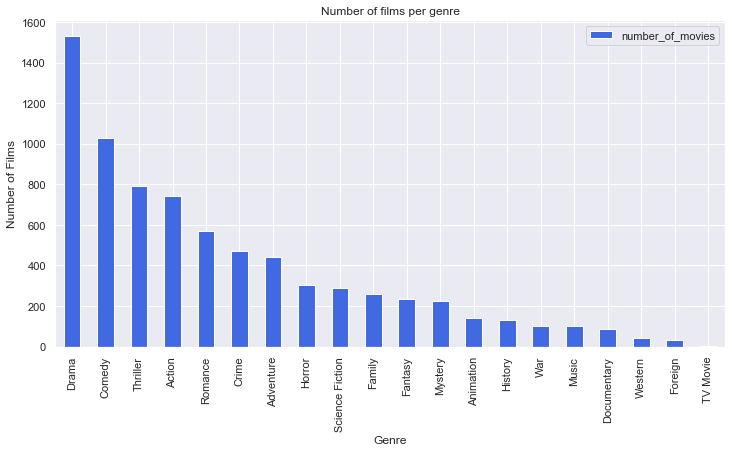

In [24]:
# plotting genres in order of number of instances in the train.csv dataset
genres_dict = dict()

for genre in train["genres_reform"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
        else:
            genres_dict[elem] += 1


sns.set(rc={'figure.figsize':(12,6)})
genres_train = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_train.columns = ["number_of_movies"]
genres_train = genres_train.sort_values(by="number_of_movies", ascending=False)
genres_train.plot.bar(color='royalblue')
plt.title("Number of films per genre")
plt.ylabel("Number of Films")
plt.xlabel("Genre")

Genres of movies follow certain trends in popularity; such as the latest boom of superhero movies originating in the 1990s with 20th Century Fox's X-Men series. Although superhero films have been around since at least 1978 with Richard Donner's Superman, the recent trend has helped define the film industry over the past two decades. For the purposes of this report, Action/Adventure films (and Fantasy) encompass superhero films, but also many other types of popular films subgenres.

Action and Adventure do relatively well in terms of number of films, so it could be hypothesized that more common genres are more popular, meaning that Drama, Comedy, and Thriller movies should see the highest respective revenues. Regardless, the importance of genre for determining the revenue of a film (and likewise predicting future success) will be highly useful given the sometimes nebulous patterns of viewership. 

In [25]:
# list of film genres by order of number of films in set
print(train['Drama'].sum())
print(train['Comedy'].sum())
print(train['Thriller'].sum())
print(train['Action'].sum())
print(train['Romance'].sum())
print(train['Crime'].sum())
print(train['Adventure'].sum())
print(train['Horror'].sum())
print(train['Science Fiction'].sum())
print(train['Family'].sum())
print(train['Fantasy'].sum())
print(train['Mystery'].sum())
print(train['Animation'].sum())
print(train['History'].sum())
print(train['War'].sum())
print(train['Music'].sum())
print(train['Documentary'].sum())
print(train['Western'].sum())
print(train['Foreign'].sum())
print(train['TV Movie'].sum())

1531
1028
789
741
571
469
439
301
290
260
232
225
141
132
100
100
87
43
31
1


In the case of genres, we see a near logarithmic function from Drama (1531 films) to TV Movies (1). It is assumed that this dataset is representative of broader filmography trends for the purposes of constructing hypotheses about the data. The more popular genres should typically see a likewise correlation in revenue given the increased popularity. However, it is worth considering the unique attraction of 'rare genre' films. Musicals like La La Land grossed S446.1 million for its Box Office total and did so with only a $30 million budget. Therefore, the possibility for outliers or even inverse hypotheses are worth considering.

### Bivariate Analysis

In [26]:
# bivariate analysis of revenue with genre
# creating a callable index for genres
genres_train.index.values
for g in genres_train.index.values:
    train[g] = train['genres_reform'].apply(lambda x: 1 if g in x else 0)

# median revenue per genre type
for i, g in enumerate(genres_train.index.values):
    genres_train.loc[g, "median_rev"] = train[train[g]==1].revenue.median()
    
genres_train.sort_values(by=["number_of_movies", "median_rev"], ascending=False).head(10)

# mean revenue for genre type
for i, g in enumerate(genres_train.index.values):
    genres_train.loc[g, "mean_rev"] = train[train[g]==1].revenue.mean()

genres_train.sort_values(by=["number_of_movies", "mean_rev"], ascending=False).head(10)

,number_of_movies,median_rev,mean_rev
Drama,1531,11293663.0,4.540607e+07
Comedy,1028,18809184.0,6.087574e+07
Thriller,789,21890845.0,6.833664e+07
Action,741,36000000.0,1.110434e+08
Romance,571,14016568.0,5.270501e+07
Crime,469,24048000.0,5.949128e+07
Adventure,439,59700000.0,1.758095e+08
Horror,301,17037887.0,5.270907e+07
Science Fiction,290,35109301.5,1.223672e+08
Family,260,57470029.5,1.388978e+08


Text(0.5, 0, 'Genre')

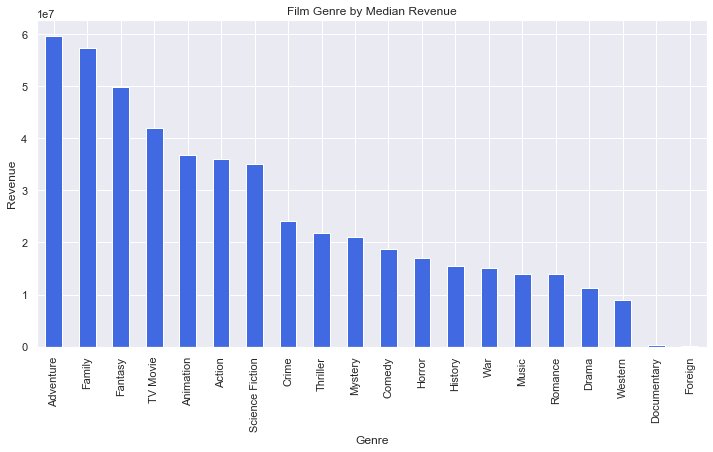

In [27]:
# genres by median revenue
genres_train.sort_values(by=["median_rev"], ascending=False).median_rev.plot.bar(color='royalblue')
plt.title("Film Genre by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

Text(0.5, 0, 'Genre')

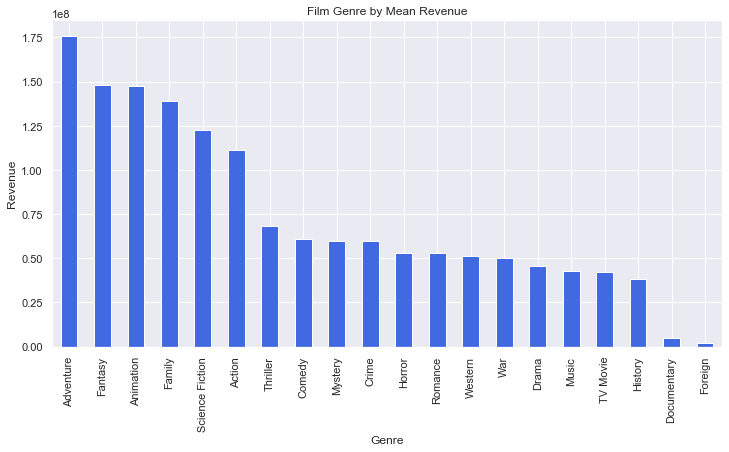

In [28]:
# genres by mean revenue
genres_train.sort_values(by=["mean_rev"], ascending=False).mean_rev.plot.bar(color='royalblue')
plt.title("Film Genre by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

In both 'Film Genre by Median Revenue' and 'Film Genre by Mean Revenue' Adventure films have the highest revenue values, with fairly consistent ordering down save a few notable changes. For example, using 'median_rev' the TV Movie genre scores fourth highest revenue, while using 'mean_rev' lowers the genre to fourth lowest revenue. History loses five places from 'median_rev' to 'mean_rev' and Comedy goes up three.

Although some common film genres (those with higher numbers of films in the training data) do well with regards to revenue, the overall hypothesis that commonality of a film would correlate positively to revenue is disproven with the relatively lower revenues for Dramas, Comedies, and Thrillers (the top three most numerous film genres). This could be a result of saturated genre demand, or it could be unrelated. What is certain is that Adventure, Family, Fantasy, and Animation score well with regards to median and mean revenue.

In [29]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_genres'], train['revenue'])
print('Pearsons correlation between num_genres and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_genres']), np.log1p(train['revenue']))
print('Pearsons correlation between num_genres and revenue: %.3f' % corr)

Pearsons correlation between num_genres and revenue: 0.164
Pearsons correlation between num_genres and revenue: 0.191


In [30]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['Adventure'], train['revenue'])
print('Pearsons correlation between Adventure and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['Adventure']), np.log1p(train['revenue']))
print('Pearsons correlation between Adventure and revenue: %.3f' % corr)

Pearsons correlation between Adventure and revenue: 0.328
Pearsons correlation between Adventure and revenue: 0.219


In [31]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['Foreign'], train['revenue'])
print('Pearsons correlation between Foreign and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['Foreign']), np.log1p(train['revenue']))
print('Pearsons correlation between Foreign and revenue: %.3f' % corr)

Pearsons correlation between Foreign and revenue: -0.048
Pearsons correlation between Foreign and revenue: -0.167


# Popularity

### Univariate Analysis

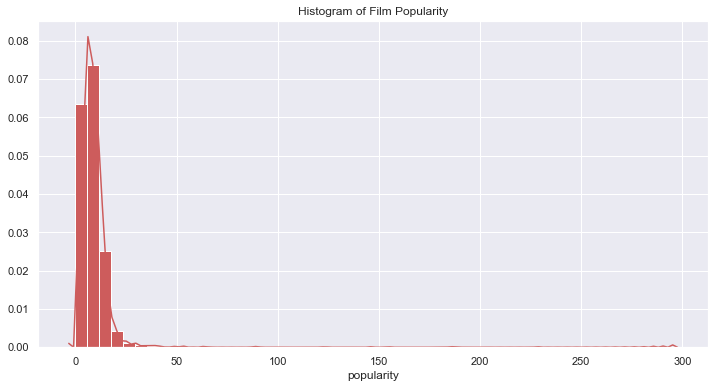

In [32]:
# plotting popularity
sns.distplot(train['popularity'], kde=True, color='indianred', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12, 2)})
plt.title('Histogram of Film Popularity')
plt.show();

In [33]:
print(train['popularity'].describe())

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


Popularity is likely to be a significant feature in prediting revenue outcome given the importance of popularity for movie viewership (this is of course contingent upon popularity refering to the 'hype' surrounding a film and not the post-release ratings - if the later than popularity should more directly map to revenue in theory). Because of the more popularity is a good thing for marketing, and thus increased ticket sales, it is hypothesized that popularity and revenue will have a positive correlation. 

Above it is seen that of the 3000 films in the dataset the average popularity was an 8.46 with a minimum of 0.00 and a max of 294.34. The histogram reveals that the bulk of the films fall between a popularity score of 0 and 25, with sparse highly popular outliers. Dealing with these outliers will be addressed later.

### Bivariate Analysis

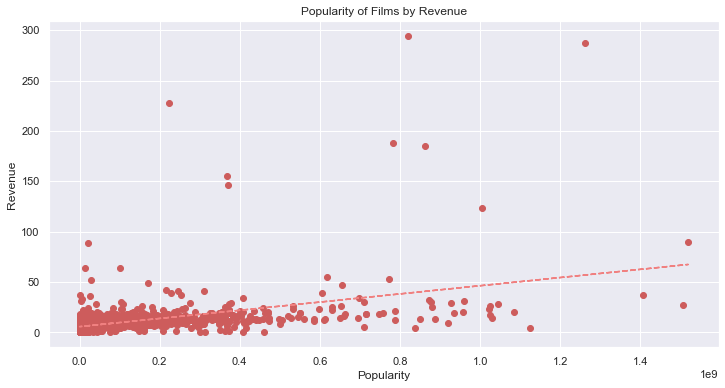

In [34]:
# bivariate: plotting popularity and revenue
sns.set(rc={'figure.figsize':(12, 6)})
cx = train['revenue']
pop = train['popularity']
plt.plot(cx, pop, 'o', color='indianred')
plt.ylabel("Revenue")
plt.xlabel("Popularity")
plt.title("Popularity of Films by Revenue")

z = np.polyfit(cx, pop, 1)
p = np.poly1d(z)
plt.plot(cx, p(cx), "--", color='lightcoral');

In comparing popularity against revenue, there is an overall positive correlation. This is to be expected given the influence of popularity on a film's monetary success via more developed viewership. Further investigation should be conducted by playing around with the outlier values; notably, certain highly popular films do not see concurrently higher revenue, which leads to the conclusion that popularity is not a perfect indicator of a movie's revenue.

However, because of the confusion regarding outliers and the scale around which this value is produced, the feature is lacking in clarity. More detrimentally, the popularity can only be judged after the film has been released, which means it is not useful to a film studio as a metric by which to predict box office totals. Instead, popularity could be used as another label (akin to the idea of predicting for a movie's "rating" as opposed to its "revenue"). Regardless, for the purposes of this project the popularity feature will not be included in the model.

In [35]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['popularity'], train['revenue'])
print('Pearsons correlation between popularity and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['popularity']), np.log1p(train['revenue']))
print('Pearsons correlation between popularity and revenue: %.3f' % corr)

Pearsons correlation between popularity and revenue: 0.461
Pearsons correlation between popularity and revenue: 0.542


# Production Studios

In [36]:
# new feature for a count of the number of production studios
train['num_studios'] = train.production_companies_reform.apply(lambda x: len(x))
print(train['num_studios'])

0       3
1       1
2       3
3       0
4       0
       ..
2995    2
2996    2
2997    3
2998    2
2999    6
Name: num_studios, Length: 3000, dtype: int64


### Univariate Analysis

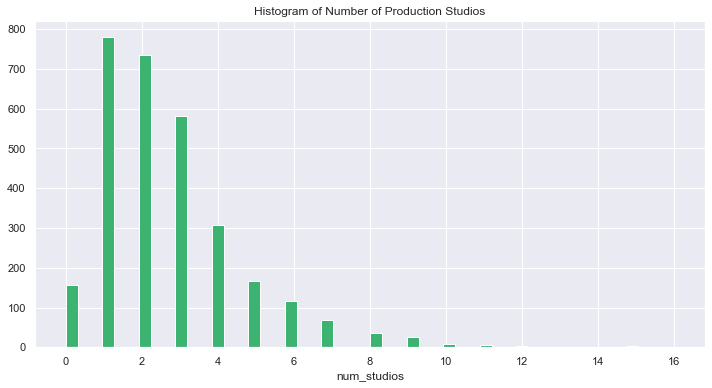

In [37]:
# plotting films by number of production studios
sns.distplot(train['num_studios'], kde=False, color='mediumseagreen', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})
plt.title('Histogram of Number of Production Studios')
plt.show();

Most movies have between 1 and 4 production studios, with fewer films having higher numbers and some even with 0 studio partners (independent films). However, given only the sheer number of production studios it is difficult to produce a reasonable hypothesis regarding the box office success of the film. Instead, determining the larger, more established, or otherwise previously successful production studios and applying those findings toward whether or not the dataset films in question have said studios would be a more useful way to analyze the impact of production companies.

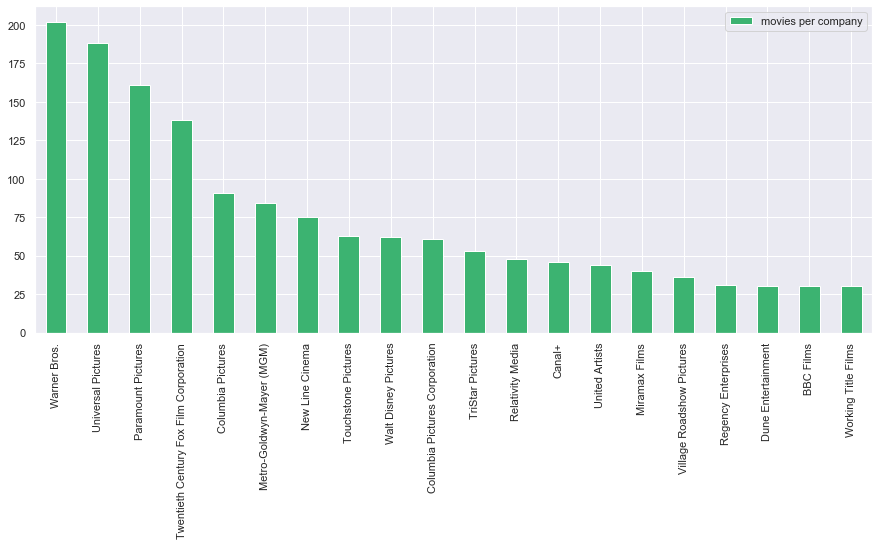

In [38]:
# production companies
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1
        else:
            companiesDict[company] += 1

companies_train = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])
companies_train.sort_values(by="movies per company", ascending=False).head(20).plot.bar(color='mediumseagreen')

companies_train.columns = ["number_of_studios"]

Using the number of movies per production company may be useful for determining what the biggest studios are, and correlating how the size of a production company influences the success of its films. There are two possibilities; either 1. a larger studio has the funding and means to draw in big-name cast and crew, with the necessary experience to turn that into a successful film project or 2. the studio is too franchised to create successful novel ideas and merely continually pumps out mediocre performing films. While some of both is likely possible, machine learning will help to weigh the relative influence of studio size on the movie's predicted revenue. Marking whether or not one of these major studios is involved in a film will be a useful feature for determining this connection.

### Bivariate Analysis

In [39]:
# # bivariate analysis of revenue with production studios
# # creating a callable index for production studios
# companies_train.index.values
# for g in companies_train.index.values:
#     train[g] = train['production_companies_reform'].apply(lambda x: 1 if g in x else 0)

# # median revenue per production studio
# for i, g in enumerate(companies_train.index.values):
#     companies_train.loc[g, "median_rev"] = train[train[g]==1].revenue.median()
    
# companies_train.sort_values(by=["number_of_studios", "median_rev"], ascending=False).head(10)

# # mean revenue per production studio
# for i, g in enumerate(companies_train.index.values):
#     companies_train.loc[g, "mean_rev"] = train[train[g]==1].revenue.mean()

# companies_train.sort_values(by=["number_of_studios", "mean_rev"], ascending=False).head(10)

# # total revenue per production studio
# for i, g in enumerate(companies_train.index.values):
#     companies_train.loc[g, "sum_rev"] = train[train[g]==1].revenue.sum()

# companies_train.sort_values(by=["number_of_studios", "sum_rev"], ascending=False).head(10)

In [40]:
# # production studios by median revenue
# companies_train.sort_values(by=["median_rev"], ascending=False).median_rev.head(20).plot.bar(color='mediumseagreen')
# plt.title("Production Studios by Median Revenue")
# plt.ylabel("Revenue")
# plt.xlabel("Production Studio")

In [41]:
# # production studios by mean revenue
# companies_train.sort_values(by=["mean_rev"], ascending=False).mean_rev.head(20).plot.bar(color='mediumseagreen')
# plt.title("Production Studios by Mean Revenue")
# plt.ylabel("Revenue")
# plt.xlabel("Production Studio")

Both mean and median revenue compared against the production studio provide relatively uninformative results. Namely, the Colorado Office of Film, Television & Media appears as a minor production studio for 'Furious 7' of the Fast & Furious Film Franchise. This is the only time it appears on the list, greatly skewing its influence on a film's revenue. Similarly, the Abu Dhabi Film Commision is involved in Furious 7 and seven other films including the highly profitable 'Ghost Rider: Spirit of Vengeance.' These outliers are unduly weighted with greater importance using this system, but other options exist.

Firstly, the total revenue of each production company can be analyzed to see the studio with the overall highest box office totals (although this is expected to mirror the largest studios with the greatest number of films). Secondly, the mean and median revenue values can be applied to only the primary production company working on a film.

In [42]:
# # production studios by total revenue
# companies_train.sort_values(by=["sum_rev"], ascending=False).sum_rev.head(20).plot.bar(color='mediumseagreen')
# plt.title("Production Studios by Total Revenue")
# plt.ylabel("Revenue")
# plt.xlabel("Production Studio")

As expected, the production studios largely mirror the studios with the largest number of films produced. One notable exception is Walt Disney Pictures which rises from ninth place in terms of films produced to fourth place for total revenue. While other studios change position some, the focus on primary studios should also be tried.

Text(0.5, 0, 'Production Studio')

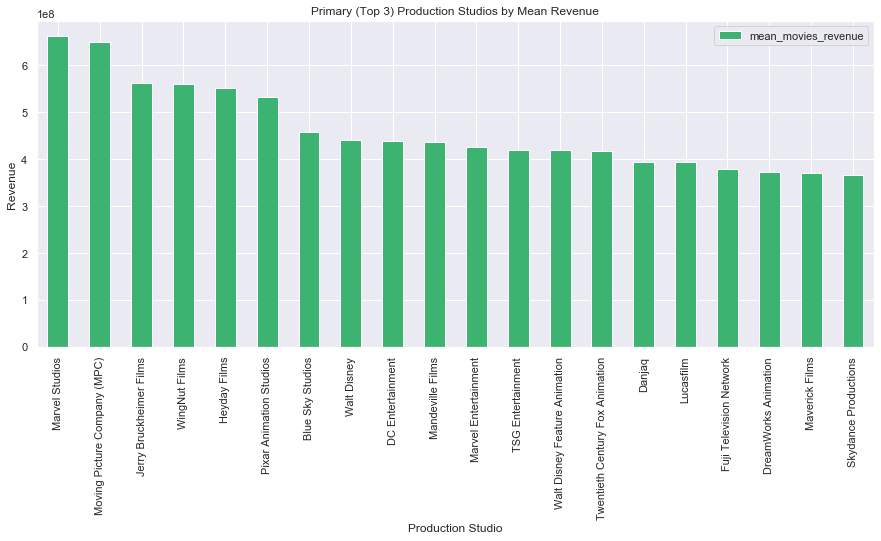

In [43]:
# isolating the primary production studios for the films
studiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
   # compare results when looking at x top production companies in films vs all affiliated studios 
    temp = 3
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in studiosDict:
            studiosDict[element[1][i]] = [element[0], 1]
        else:
            studiosDict[element[1][i]][0] += element[0]
            studiosDict[element[1][i]][1] += 1    

studiosDict = {k: v for k, v in studiosDict.items() if v[1] >= 3}

for company in studiosDict:
    studiosDict[company][0] = studiosDict[company][0]/studiosDict[company][1]
    studiosDict[company] = studiosDict[company][0]


    
    
studios_train = pd.DataFrame.from_dict(studiosDict, orient='index', columns=["mean_movies_revenue"])
studios_train.sort_values(by="mean_movies_revenue", ascending=False).head(20).plot.bar(color='mediumseagreen')
plt.title("Primary (Top 3) Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

When isolating the top three production studios from an example's production_companies feature, a different barplot for production studio by mean revenue is produced. Notably, the film commissions associated with regional media permitting only associated with one or several films with high revenue (see the Colorado Office of Film, Television & Media's listing on 'Furious 7') are eliminated from this method for analyzing the production studios. This allows for a more effective usage of mean revenue based on the primary studios, while also more appropriately treating the issue of studios with immense filmographies (such as Warner Bros.) receiving too high of a value for 'total revenue.'

In [44]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_studios'], train['revenue'])
print('Pearsons correlation between num_studios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_studios']), np.log1p(train['revenue']))
print('Pearsons correlation between num_studios and revenue: %.3f' % corr)

Pearsons correlation between num_studios and revenue: 0.154
Pearsons correlation between num_studios and revenue: 0.269


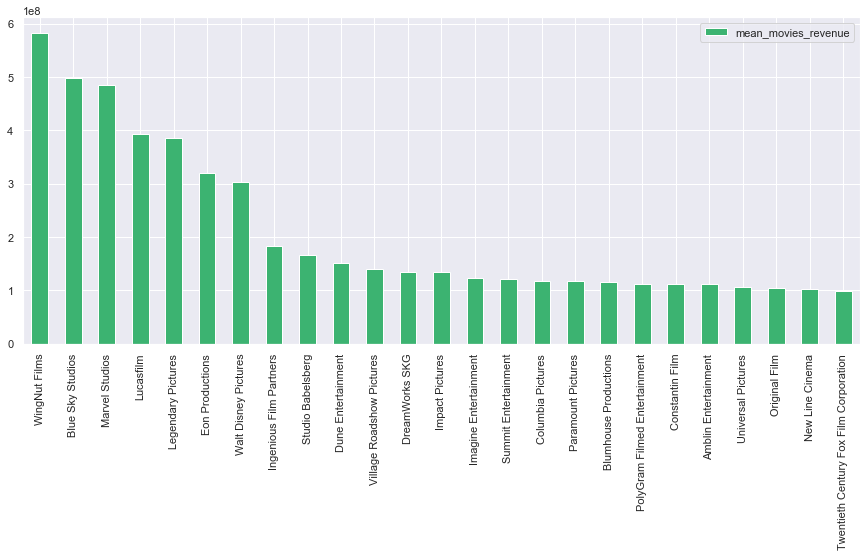

In [45]:
topStudiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
   # compare results when looking at x top studios
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topStudiosDict:
            topStudiosDict[element[1][i]] = [element[0], 1]
        else:
            topStudiosDict[element[1][i]][0] += element[0]
            topStudiosDict[element[1][i]][1] += 1    

topStudiosDict = {k: v for k, v in topStudiosDict.items() if v[1] >= 5}

for company in topStudiosDict:
    topStudiosDict[company][0] = topStudiosDict[company][0]/topStudiosDict[company][1]
    topStudiosDict[company] = topStudiosDict[company][0]


    
    
studios_train = pd.DataFrame.from_dict(topStudiosDict, orient='index', columns=["mean_movies_revenue"])
studios_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='mediumseagreen')


In [46]:
# Sort both of our dicts of studios and top studios to more easily access the 'most successful studios'
topStudiosDict = {k: v for k, v in sorted(topStudiosDict.items(), key=lambda item: item[1], reverse = True)}
studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top studio'
def checkTopStudios(studio):
    if len(studio) < 1 or studio[0] not in list(topStudiosDict)[:25]:
        return 0
    else:
        return 1

def checkStudios(studio):
    if len(studio) < 1:
        return 0
    count = 0
    for company in studio[:5]:
        if company in list(studiosDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD actors
train['topStudio'] = train['production_companies_reform'].apply(lambda x: checkTopStudios(x))
#Creating feature for number of top actors
train['numTopStudios'] = train['production_companies_reform'].apply(lambda x: checkStudios(x))


print(train['topStudio'].value_counts())
print()
print(train['numTopStudios'].value_counts())

0    2144
1     856
Name: topStudio, dtype: int64

0    2188
1     602
2     157
3      48
4       5
Name: numTopStudios, dtype: int64


# Release Date

In [47]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
train_date = train['release_date']

# converting to datetime format, with .dt used for accessing quantities
train_date = pd.to_datetime(train_date)
train_date.dt
print(train_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [48]:
# possible output options
print(train_date.dt.year) # absolutely necessary
print(train_date.dt.dayofweek) # friday night hits!
print(train_date.dt.dayofyear) # it's a christmas miracle
print(train_date.dt.weekofyear) # of interest

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int64
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int64
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int64
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: release_date, Length: 3000, dtype: int64


In [49]:
print(train.release_date.describe())
print()
print(train_date.dt.year.describe())

count        3000
unique       2398
top       9/10/15
freq            5
Name: release_date, dtype: object

count    3000.000000
mean     2004.779667
std        15.664767
min      1970.000000
25%      1995.000000
50%      2006.000000
75%      2012.000000
max      2069.000000
Name: release_date, dtype: float64


### Univariate Analysis

Text(0.5, 1.0, 'Year of Release Date by Number of Films')

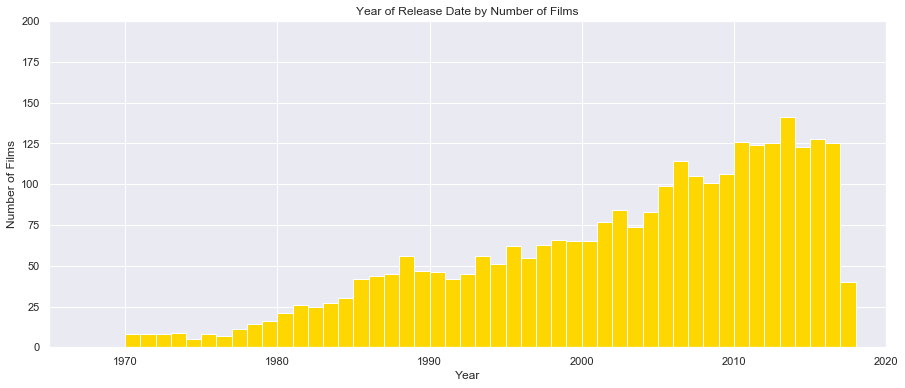

In [50]:
# plotting the year of the films release
fig, dx = plt.subplots()
sns.distplot(train_date.dt.year, bins=99, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(1965, 2020),ylim=(0,200))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Release Date by Number of Films")

The plot for year of release for the dataset shows a general increase in number of films as time progresses, which makes sense for a growing/maturing industry. While mostly linear, there are several peaks throughout. Finding a relationship between the years with above average number films and revenue could be an interesting direction for investigation.

[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, '')]

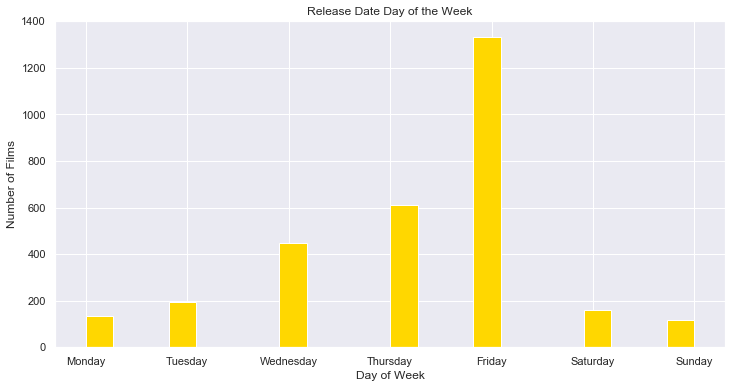

In [51]:
# plotting the films release day of the week
fig, ex = plt.subplots()
sns.distplot(train_date.dt.dayofweek, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Release Date Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

The dayofweek data shows a clear outlier in Friday release days, which is somewhat obviously tied to the end of the common Monday to Friday five day workweek. Individuals are more likely to attend a several hour long event after work if they have fewer responsibilities the following day. A movie's release is expected to follow market patterns that best benefit the film, so it is hypothesized that Friday release dates will have a positive impact on sales (and by association box office totals). Unexpectedly, Saturday release dates are lower even than Tuesday, Wednesday, and Thursday - it might be logical to assume many movie-goers would attend a film opening on Saturday.

Text(0.5, 1.0, 'Release Date Day of the Year')

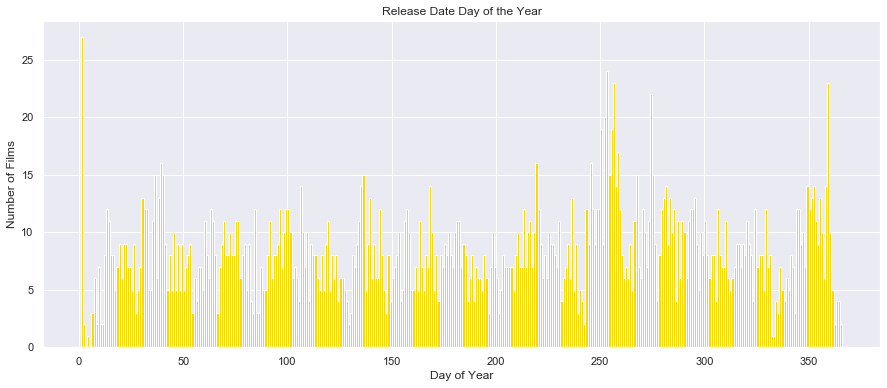

In [52]:
# plotting the films release day of the year
fig, fx = plt.subplots()
sns.distplot(train_date.dt.dayofyear, bins=365, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

The dayofyear data is a fairly noisy set of data, however as expected, there are certain days with notably higher numbers of films produced. For example, the Christmas Eve and New Years Day release dates are well-known as popular choices for when to release a movie. Whether this is an advent largely born out of tradition or out of true benefit to revenue will be parsed in later data exploration. 

There is also a clumping of films curiously released in September. Further research reveals that August and September are among the months listed as 'dump months' during which a large number of films that did bad in testing, star a less prominent cast, or otherwise cannot be easily marketted. This aligns with the return of children to the public school system after summer as well as other indicators of a slump period for the film industry. So high number of releases could be positive in some cases and negative in others. In fact, periods with low release may be due to a major title opening (with the studios wanting less box office competition).

Text(0.5, 1.0, 'Release Date Month of the Year')

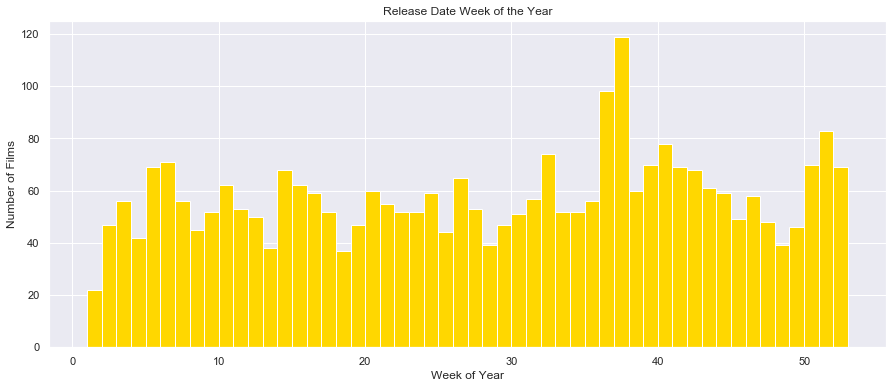

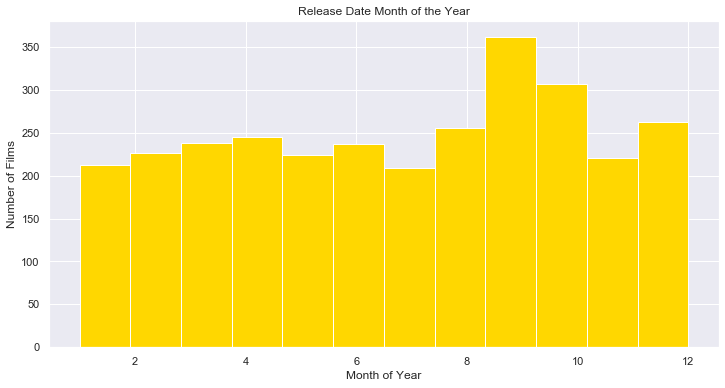

In [53]:
# plotting the films release week of the year
fig, gx = plt.subplots()
sns.distplot(train_date.dt.weekofyear, bins=52, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Number of Films")
gx.set_title("Release Date Week of the Year")

print()

# plotting the films release month of the year
fig, hx = plt.subplots()
sns.distplot(train_date.dt.month, bins=12, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date Month of the Year")

Similarly to the dayofyear data, the weekofyear data shows the highest number of films released at the end of August and beginning of September. As the 'dump months' this is unlikely to be indicative of a positive correlation with revenue. The second largest spike in December may have better box office totals due to the popularity of going to the movies over the holidays. Late Fall into Winter are typically denoted as the beginning of Oscar Season, which could mean higher grossing films released regardless of the overall number of film. As such, it can be theorized that the number of films released in a given week of the year is not as important as the characteristics of that week with respect to the film industry's cyclical patterns.

### Bivariate Analysis

[Text(0, 0, '1970'),
 Text(0, 0, '1971'),
 Text(0, 0, '1972'),
 Text(0, 0, '1973'),
 Text(0, 0, '1974'),
 Text(0, 0, '1975'),
 Text(0, 0, '1976'),
 Text(0, 0, '1977'),
 Text(0, 0, '1978'),
 Text(0, 0, '1979'),
 Text(0, 0, '1980'),
 Text(0, 0, '1981'),
 Text(0, 0, '1982'),
 Text(0, 0, '1983'),
 Text(0, 0, '1984'),
 Text(0, 0, '1985'),
 Text(0, 0, '1986'),
 Text(0, 0, '1987'),
 Text(0, 0, '1988'),
 Text(0, 0, '1989'),
 Text(0, 0, '1990'),
 Text(0, 0, '1991'),
 Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '

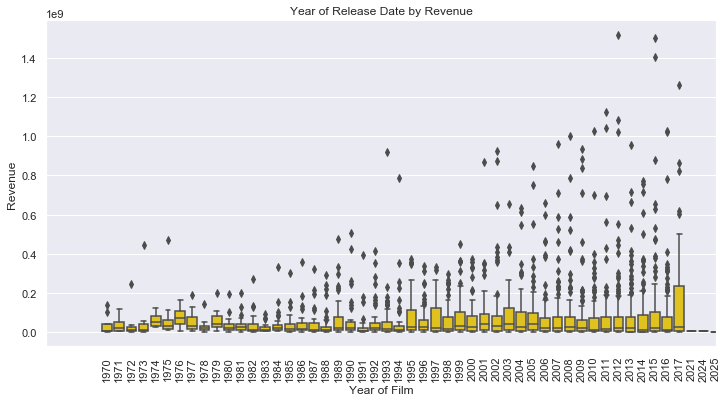

In [54]:
# bivariate year of release with revenue data
fig, dx = plt.subplots()
sns.boxplot(x=train_date.dt.year, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(-5, 50))
dx.set_xlabel("Year of Film")
dx.set_ylabel("Revenue")
dx.set_title("Year of Release Date by Revenue")

dx.set_xticklabels(dx.get_xticklabels(), rotation=90)

The revenue of films generally increases from year to year, with some notably higher years than others. The latest year in the dataset, 2017, has far an away the highest revenue in no small part because of Wonder Woman.

[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

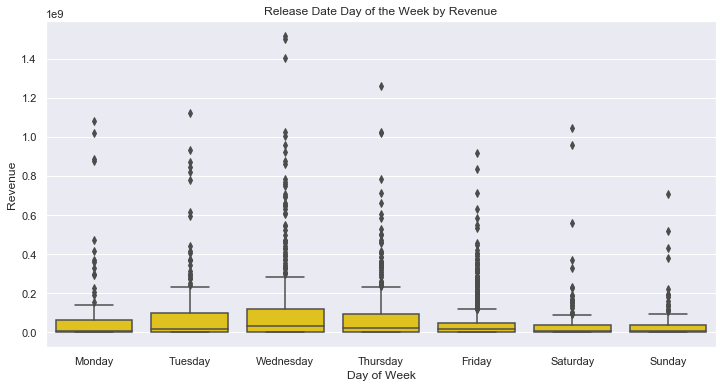

In [55]:
# bivariate day of week of release with revenue data
fig, ex = plt.subplots()
sns.boxplot(x=train_date.dt.dayofweek, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Revenue")
ex.set_title("Release Date Day of the Week by Revenue")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
labels[5] = 'Saturday'
labels[6] = 'Sunday'

ex.set_xticklabels(labels)


Surprisingly, despite the hypothesis that Friday was the most common release date because of some monetary benefit to sales, Wednesday (followed by Tuesday & Thursday) has the highest revenue. It would be interesting to investigate why this is the case, but regardless it will help inform the outcome of the model.

Text(0.5, 1.0, 'Release Date Day of the Year by Revenue')

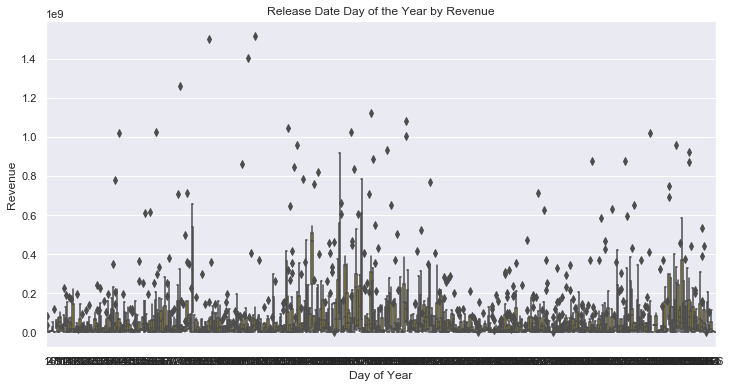

In [56]:
# bivariate day of year of release with revenue data
# WIP
fig, fx = plt.subplots()
sns.boxplot(x=train_date.dt.dayofyear, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Revenue")
fx.set_title("Release Date Day of the Year by Revenue")

The sheer amount of data is difficult to present in the same format as the other release_date by revenue bivariate analysis plots.

Text(0.5, 1.0, 'Release Date Week of the Year by Revenue')

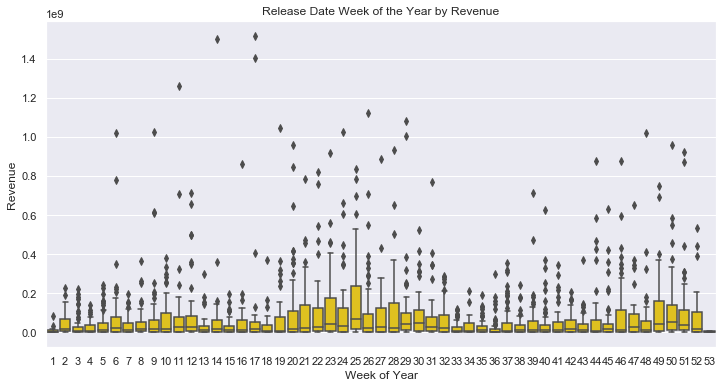

In [57]:
fig, gx = plt.subplots()
sns.boxplot(x=train_date.dt.weekofyear, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Revenue")
gx.set_title("Release Date Week of the Year by Revenue")

The revenue for weeks of the year match fairly well with the expected results from the univariate analysis, with the weeks preceding the holiday season having relatively high revenue. There is also a notable midsummer peak season in June (the 25th week of the year).

Text(0.5, 1.0, 'Release Date Month by Revenue')

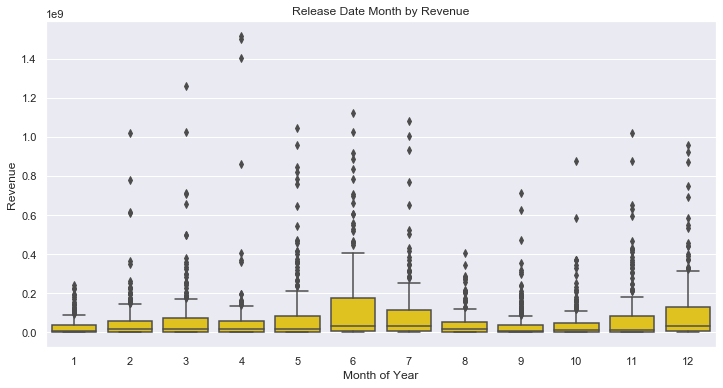

In [58]:
fig, hx = plt.subplots()
sns.boxplot(x=train_date.dt.month, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Revenue")
hx.set_title("Release Date Month by Revenue")

Similarly to above, the month of the year follows a similar trend. The midsummer months are successful, although not numerous in terms of release, while the 'dump months' during the start of the school year have a higher number of films and significantly lower revenue. The holiday season in December shows a higher number of releases and a concurrently higher revenue.

In [59]:
# fill possible NA values with the statistical mode
train["release_date"] = train["release_date"].fillna(train["release_date"].mode()[0])

train['temp'] = train.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

train["month"] = train.temp.apply(lambda x: x.month)
train["season"] = train["month"]%4
train["year"] = train.temp.apply(lambda x: x.year)
train["day_of_week"] = train.temp.apply(lambda x: x.weekday()+1)
train["week_of_year"] = train.temp.apply(lambda x: x.isocalendar()[1])

train = train.drop(['temp'], axis=1)


train["day_of_week"] = train["day_of_week"].fillna(train["day_of_week"].mode()[0])

train["year"] = train["year"].fillna(train["year"].mode()[0])

train["month"] = train["month"].fillna(train["month"].mode()[0])

train["week_of_year"] = train["week_of_year"].fillna(train["week_of_year"].mode()[0])

train["season"] = train["season"].fillna(train["season"].mode()[0])

train[["release_date", "month", "year", "day_of_week", "week_of_year", "season"]].head()

,release_date,month,year,day_of_week,week_of_year,season
0,2/20/15,2,2015,5,8,2
1,8/6/04,8,2004,5,32,0
2,10/10/14,10,2014,5,41,2
3,3/9/12,3,2012,5,10,3
4,2/5/09,2,2009,4,6,2


In [60]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['day_of_week'], train['revenue'])
print('Pearsons correlation between day_of_week and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['day_of_week']), np.log1p(train['revenue']))
print('Pearsons correlation between day_of_week and revenue: %.3f' % corr)

Pearsons correlation between day_of_week and revenue: -0.141
Pearsons correlation between day_of_week and revenue: -0.023


In [61]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['year'], train['revenue'])
print('Pearsons correlation between year and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['year']), np.log1p(train['revenue']))
print('Pearsons correlation between year and revenue: %.3f' % corr)

Pearsons correlation between year and revenue: 0.021
Pearsons correlation between year and revenue: -0.072


In [62]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['month'], train['revenue'])
print('Pearsons correlation between month and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['month']), np.log1p(train['revenue']))
print('Pearsons correlation between month and revenue: %.3f' % corr)

Pearsons correlation between month and revenue: 0.020
Pearsons correlation between month and revenue: 0.041


In [63]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['week_of_year'], train['revenue'])
print('Pearsons correlation between week_of_year and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['week_of_year']), np.log1p(train['revenue']))
print('Pearsons correlation between week_of_year and revenue: %.3f' % corr)

Pearsons correlation between week_of_year and revenue: 0.017
Pearsons correlation between week_of_year and revenue: 0.030


In [64]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['season'], train['revenue'])
print('Pearsons correlation between season and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['season']), np.log1p(train['revenue']))
print('Pearsons correlation between season and revenue: %.3f' % corr)

Pearsons correlation between season and revenue: 0.053
Pearsons correlation between season and revenue: -0.007


# Spoken Languages

In [111]:
# new feature for a count of the number of spoken languages
train['num_languages'] = train.spoken_languages_reform.apply(lambda x: len(x))
print(train['num_languages'])

test['num_languages'] = test.spoken_languages_reform.apply(lambda x: len(x))
print(test['num_languages'])

0       1
1       1
2       1
3       2
4       1
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: num_languages, Length: 3000, dtype: int64
0       2
1       1
2       1
3       3
4       1
       ..
4393    5
4394    1
4395    1
4396    1
4397    1
Name: num_languages, Length: 4398, dtype: int64


In [66]:
print(train.num_languages.describe())

count    3000.000000
mean        1.443000
std         0.880725
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: num_languages, dtype: float64


### Univariate Analysis

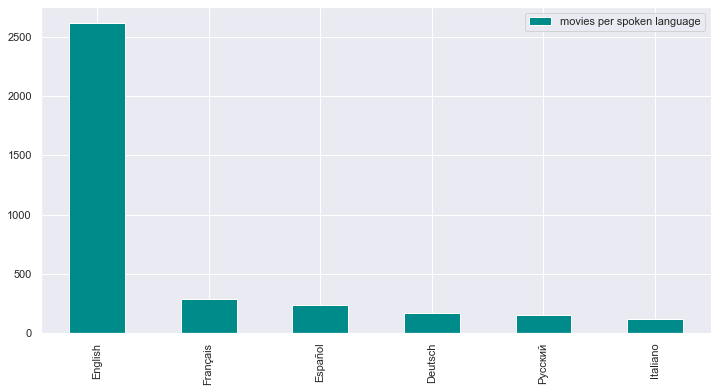

In [69]:
# univariate analysis of spoken languages
languagesDict = {}
for element in train["spoken_languages_reform"].values:
    for name in element:
        if name not in languagesDict:
            languagesDict[name] = 1
        else:
            languagesDict[name] += 1

languages_train = pd.DataFrame.from_dict(languagesDict, orient='index', columns=["movies per spoken language"])
languages_train.sort_values(by="movies per spoken language", ascending=False).head(6).plot.bar(color='darkcyan')

languages_train.columns = ["number_of_languages"]

Due to the significantly higher value for films with English as the spoken language, this value can likely be broken down to a simple, "Is English a spoken language or not?" This will provide interesting insight into the importance of English as the spoken language as a factor toward the movie's success. Because of the higher market for movies in English speaking countries (save perhaps India - although it is unclear if an appropriately proportioned number of Bollywood films are included in the training data). A sound hypothesis would be that English may not denote a successful movie, but an absence of English may harm the film's chance for being as successful.

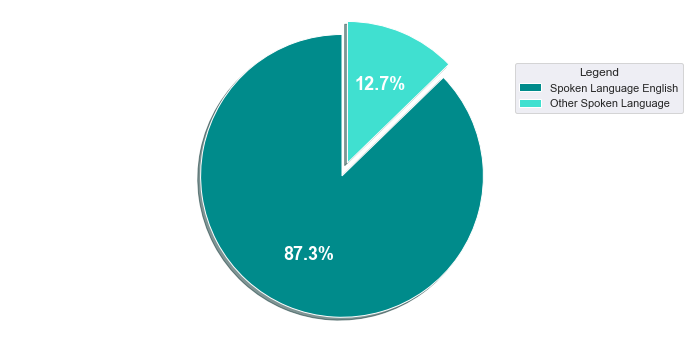

In [112]:
# spoken languages (english vs non-english)
train['lang'] = train['spoken_languages_reform'].apply(lambda x: 1 if 'English' in x else 0)
test['lang'] = test['spoken_languages_reform'].apply(lambda x: 1 if 'English' in x else 0)

lang = [sum(train.lang), (train.lang == 0).sum(axis=0)]
lang_test = [sum(test.lang), (test.lang == 0).sum(axis=0)]

labels = 'Spoken Language English', 'Other Spoken Language'
explode = (0.1, 0)

# plot
colors = ["darkcyan", "turquoise"]

fig, ix = plt.subplots()
ix.pie(lang, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize':18, 'weight':"bold"})
ix.axis('equal')

ix.legend(labels,
          title="Legend",
          loc="center left",
          bbox_to_anchor=(0.75, 0.25, 0.5, 1))

### Bivariate Analysis

English is Spoken Language        2618
English is Not Spoken Language     382
Name: eng, dtype: int64
English is Spoken Language        3831
English is Not Spoken Language     567
Name: eng, dtype: int64


Text(0.5, 0, 'Language Status')

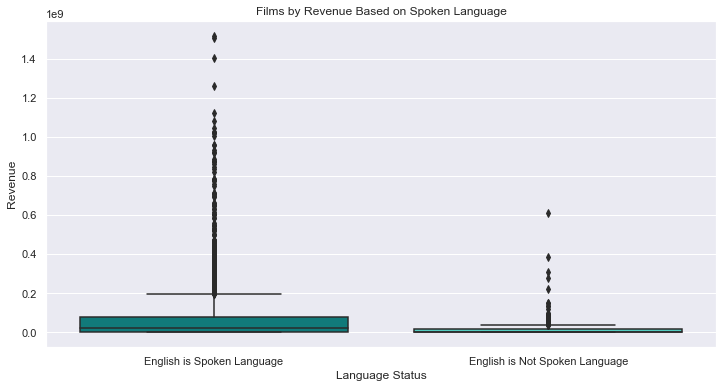

In [113]:
# bivariate analysis of revenue with english as spoken language
train['eng'] = train['lang'].apply(lambda x: 'English is Spoken Language' if x == 1 else 'English is Not Spoken Language')
print(train['eng'].value_counts())

test['eng'] = test['lang'].apply(lambda x: 'English is Spoken Language' if x == 1 else 'English is Not Spoken Language')
print(test['eng'].value_counts())

pal2 = ["darkcyan", "turquoise"]

sns.set(rc={'figure.figsize':(12, 6)})
sns.boxplot(x='eng', y='revenue', data=train, palette=pal2)
plt.title('Films by Revenue Based on Spoken Language')
plt.ylabel("Revenue")
plt.xlabel("Language Status")

In [72]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['lang'], train['revenue'])
print('Pearsons correlation between lang and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['lang']), np.log1p(train['revenue']))
print('Pearsons correlation between lang and revenue: %.3f' % corr)

Pearsons correlation between lang and revenue: 0.135
Pearsons correlation between lang and revenue: 0.229


In [73]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_languages'], train['revenue'])
print('Pearsons correlation between num_languages and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_languages']), np.log1p(train['revenue']))
print('Pearsons correlation between num_languages and revenue: %.3f' % corr)

Pearsons correlation between num_languages and revenue: 0.065
Pearsons correlation between num_languages and revenue: 0.123


# Crew

### Univariate Analysis

In [74]:
# pre-processing
train.crew = train.crew.fillna("")
train['crew_processed'] = train['crew'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

In [75]:
train.crew.head()

0    [{'credit_id': '59ac067c92514107af02c8c8', 'de...
1    [{'credit_id': '52fe43fe9251416c7502563d', 'de...
2    [{'credit_id': '54d5356ec3a3683ba0000039', 'de...
3    [{'credit_id': '52fe48779251416c9108d6eb', 'de...
4    [{'credit_id': '52fe464b9251416c75073b43', 'de...
Name: crew, dtype: object

In [76]:
train.crew.describe()

count     3000
unique    2985
top           
freq        16
Name: crew, dtype: object

### Bivariate Analysis

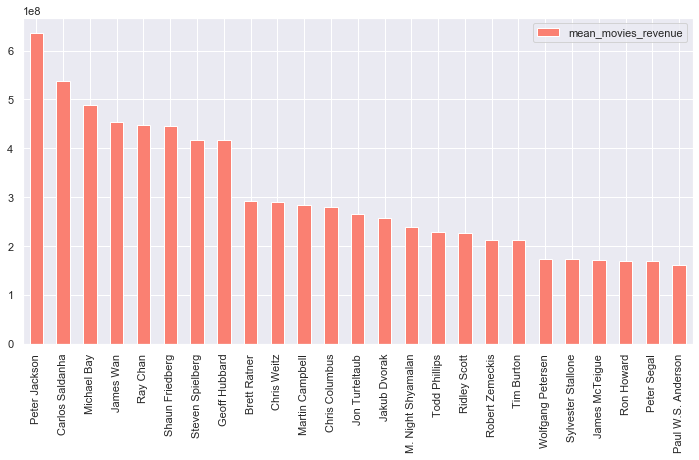

In [77]:
# bivariate directors
train['directors'] = train['crew'].apply(lambda x: re.findall("Director', 'name': '(.+?)'", x))

directorsDict = {}
for element in train[["revenue", "directors"]].values:

    for director in element[1]:
        if director not in directorsDict:
            directorsDict[director] = [element[0], 1]
        else:
            directorsDict[director][0] += element[0]
            directorsDict[director][1] += 1

directorsDict = {k: v for k, v in directorsDict.items() if v[1] >= 5}

for director in directorsDict:
    directorsDict[director][0] = directorsDict[director][0]/directorsDict[director][1]
    directorsDict[director] = directorsDict[director][0]

    
directors_train = pd.DataFrame.from_dict(directorsDict, orient='index', columns=["mean_movies_revenue"])
directors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

directors_train.columns = ["number_of_directors"]

The plot above shows the top 25 directors by mean revenue for all of the movies they have produced. Because of the goal of the project to predict box office totals for an unknown example, ranking directors in order of their box office success will allow us to create a feature indicative of whether a top director is associated with a movie or not. Given that these directors are the more influential toward revenue in the training set of data, denoting their presence in test data should be a good predictor of future success. This obviously doesn't account for flubs. Botched films can come from great directors, but are likely outliers more than the norm. It is hypothesized that more successful directors with respect to revenue will be an influential factor in predicting the success of their future film projects.

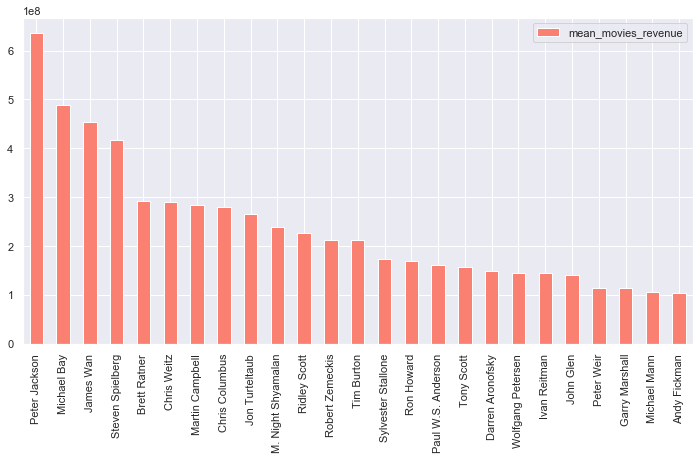

In [78]:
leadDirectorsDict = {}
for element in train[["revenue", "directors"]].values:
   # compare results when looking at x top directors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadDirectorsDict:
            leadDirectorsDict[element[1][i]] = [element[0], 1]
        else:
            leadDirectorsDict[element[1][i]][0] += element[0]
            leadDirectorsDict[element[1][i]][1] += 1    

leadDirectorsDict = {k: v for k, v in leadDirectorsDict.items() if v[1] >= 5}

for director in leadDirectorsDict:
    leadDirectorsDict[director][0] = leadDirectorsDict[director][0]/leadDirectorsDict[director][1]
    leadDirectorsDict[director] = leadDirectorsDict[director][0]


    
    
directors_train = pd.DataFrame.from_dict(leadDirectorsDict, orient='index', columns=["mean_movies_revenue"])
directors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [79]:
# Sort both of our dicts
leadDirectorsDict = {k: v for k, v in sorted(leadDirectorsDict.items(), key=lambda item: item[1], reverse = True)}
directorsDict = {k: v for k, v in sorted(directorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadDirector(crew):
    if len(crew) < 1 or crew[0] not in list(leadDirectorsDict)[:25]:
        return 0
    else:
        return 1

def checkTopDirectors(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(directorsDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD directors
train['topLeadDirector'] = train['directors'].apply(lambda x: checkLeadDirector(x))
test['topLeadDirector'] = test['directors'].apply(lambda x: checkLeadDirector(x))

#Creating feature for number of top directors
train['numTopDirectors'] = train['directors'].apply(lambda x: checkTopDirectors(x))
test['numTopDirectors'] = test['directors'].apply(lambda x: checkTopDirectors(x))


print(train['topLeadDirector'].value_counts())
print()
print(train['numTopDirectors'].value_counts())

0    2848
1     152
Name: topLeadDirector, dtype: int64

0    2500
1     489
2      10
3       1
Name: numTopDirectors, dtype: int64


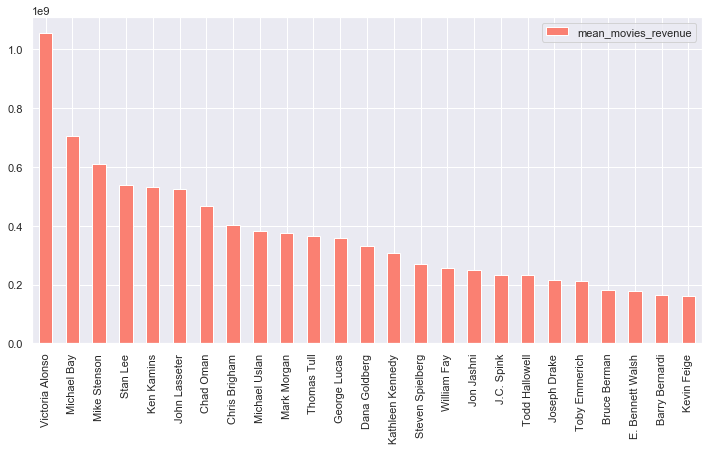

In [80]:
# bivariate executive producers
train['exec_producers'] = train['crew'].apply(lambda x: re.findall("Executive Producer', 'name': '(.+?)'", x))

exec_producersDict = {}
for element in train[["revenue", "exec_producers"]].values:

    for exec_producer in element[1]:
        if exec_producer not in exec_producersDict:
            exec_producersDict[exec_producer] = [element[0], 1]
        else:
            exec_producersDict[exec_producer][0] += element[0]
            exec_producersDict[exec_producer][1] += 1

exec_producersDict = {k: v for k, v in exec_producersDict.items() if v[1] >= 5}

for exec_producer in exec_producersDict:
    exec_producersDict[exec_producer][0] = exec_producersDict[exec_producer][0]/exec_producersDict[exec_producer][1]
    exec_producersDict[exec_producer] = exec_producersDict[exec_producer][0]




exec_producers_train = pd.DataFrame.from_dict(exec_producersDict, orient='index', columns=["mean_movies_revenue"])
exec_producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

Similarly to the top directors by revenue, the top executive producers by revenue should be a good feature for determining the future success of a film with the same crew. Executive producers are merely another important instance of analyzing the impact of crew members on predicting box office totals. This can be done with any category of crew member.

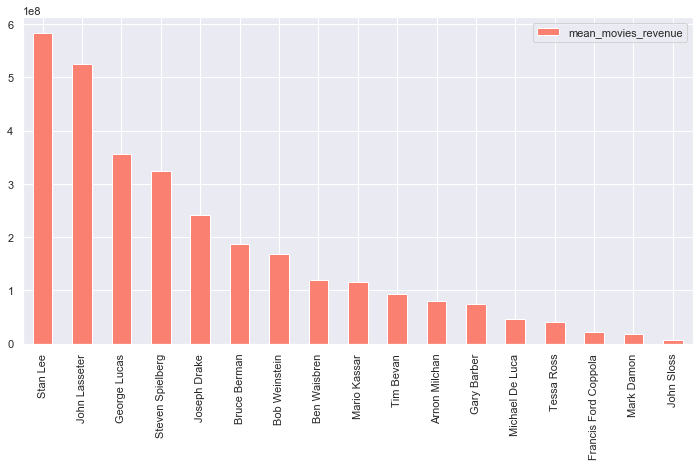

In [81]:
leadExecProdDict = {}
for element in train[["revenue", "exec_producers"]].values:
   # compare results when looking at x top exec producers in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadExecProdDict:
            leadExecProdDict[element[1][i]] = [element[0], 1]
        else:
            leadExecProdDict[element[1][i]][0] += element[0]
            leadExecProdDict[element[1][i]][1] += 1    

leadExecProdDict = {k: v for k, v in leadExecProdDict.items() if v[1] >= 5}

for exec_producer in leadExecProdDict:
    leadExecProdDict[exec_producer][0] = leadExecProdDict[exec_producer][0]/leadExecProdDict[exec_producer][1]
    leadExecProdDict[exec_producer] = leadExecProdDict[exec_producer][0]


    
    
exec_producers_train = pd.DataFrame.from_dict(leadExecProdDict, orient='index', columns=["mean_movies_revenue"])
exec_producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [82]:
# Sort both of our dicts
leadExecProdDict = {k: v for k, v in sorted(leadExecProdDict.items(), key=lambda item: item[1], reverse = True)}
exec_producersDict = {k: v for k, v in sorted(exec_producersDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadExecProd(crew):
    if len(crew) < 1 or crew[0] not in list(leadExecProdDict)[:25]:
        return 0
    else:
        return 1

def checkTopExecProd(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(exec_producersDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD execprod
train['topLeadExecProd'] = train['exec_producers'].apply(lambda x: checkLeadExecProd(x))
test['topLeadExecProd'] = test['exec_producers'].apply(lambda x: checkLeadExecProd(x))

#Creating feature for number of top execprod
train['numTopExecProd'] = train['exec_producers'].apply(lambda x: checkTopExecProd(x))
test['numTopExecProd'] = test['exec_producers'].apply(lambda x: checkTopExecProd(x))


print(train['topLeadExecProd'].value_counts())
print()
print(train['numTopExecProd'].value_counts())

0    2860
1     140
Name: topLeadExecProd, dtype: int64

0    2631
1     236
2     106
3      20
4       6
5       1
Name: numTopExecProd, dtype: int64


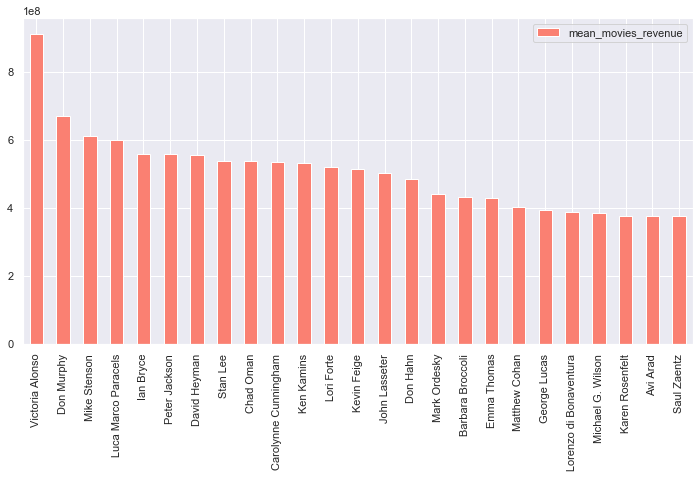

In [83]:
# bivariate producers
train['producers'] = train['crew'].apply(lambda x: re.findall("Producer', 'name': '(.+?)'", x))

producersDict = {}
for element in train[["revenue", "producers"]].values:

    for producer in element[1]:
        if producer not in producersDict:
            producersDict[producer] = [element[0], 1]
        else:
            producersDict[producer][0] += element[0]
            producersDict[producer][1] += 1

producersDict = {k: v for k, v in producersDict.items() if v[1] >= 5}

for producer in producersDict:
    producersDict[producer][0] = producersDict[producer][0]/producersDict[producer][1]
    producersDict[producer] = producersDict[producer][0]




producers_train = pd.DataFrame.from_dict(producersDict, orient='index', columns=["mean_movies_revenue"])
producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

Changing the search from "Executive Producer" to "Producer" provides different results with some similar/overlapping data.

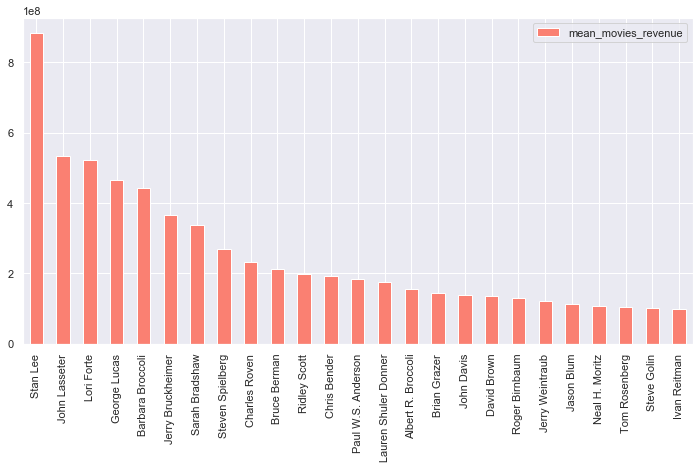

In [84]:
leadProducerDict = {}
for element in train[["revenue", "producers"]].values:
   # compare results when looking at x top producers in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadProducerDict:
            leadProducerDict[element[1][i]] = [element[0], 1]
        else:
            leadProducerDict[element[1][i]][0] += element[0]
            leadProducerDict[element[1][i]][1] += 1    

leadProducerDict = {k: v for k, v in leadProducerDict.items() if v[1] >= 5}

for producer in leadProducerDict:
    leadProducerDict[producer][0] = leadProducerDict[producer][0]/leadProducerDict[producer][1]
    leadProducerDict[producer] = leadProducerDict[producer][0]


    
    
producers_train = pd.DataFrame.from_dict(leadProducerDict, orient='index', columns=["mean_movies_revenue"])
producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [85]:
# Sort both of our dicts
leadProducerDict = {k: v for k, v in sorted(leadProducerDict.items(), key=lambda item: item[1], reverse = True)}
producersDict = {k: v for k, v in sorted(producersDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top producer'
def checkLeadProducer(crew):
    if len(crew) < 1 or crew[0] not in list(leadProducerDict)[:25]:
        return 0
    else:
        return 1

def checkTopProducers(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for producer in crew[:5]:
        if producer in list(producersDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD Producers
train['topLeadProducer'] = train['producers'].apply(lambda x: checkLeadProducer(x))
test['topLeadProducer'] = test['producers'].apply(lambda x: checkLeadProducer(x))

#Creating feature for number of top Producers
train['numTopProducers'] = train['producers'].apply(lambda x: checkTopProducers(x))
test['numTopProducers'] = test['producers'].apply(lambda x: checkTopProducers(x))


print(train['topLeadProducer'].value_counts())
print()
print(train['numTopProducers'].value_counts())

0    2799
1     201
Name: topLeadProducer, dtype: int64

0    2591
1     249
2      89
3      47
4      17
5       7
Name: numTopProducers, dtype: int64


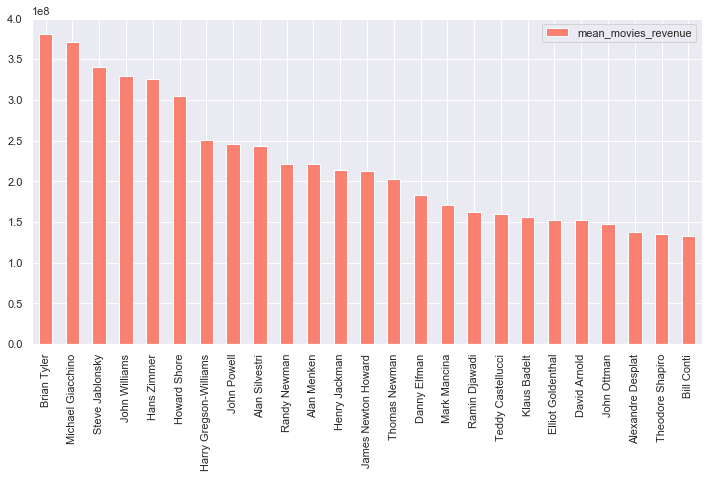

In [86]:
# bivariate composer
train['composers'] = train['crew'].apply(lambda x: re.findall("Composer', 'name': '(.+?)'", x))

composersDict = {}
for element in train[["revenue", "composers"]].values:

    for composer in element[1]:
        if composer not in composersDict:
            composersDict[composer] = [element[0], 1]
        else:
            composersDict[composer][0] += element[0]
            composersDict[composer][1] += 1

composersDict = {k: v for k, v in composersDict.items() if v[1] >= 5}

for composer in composersDict:
    composersDict[composer][0] = composersDict[composer][0]/composersDict[composer][1]
    composersDict[composer] = composersDict[composer][0]




composers_train = pd.DataFrame.from_dict(composersDict, orient='index', columns=["mean_movies_revenue"])
composers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

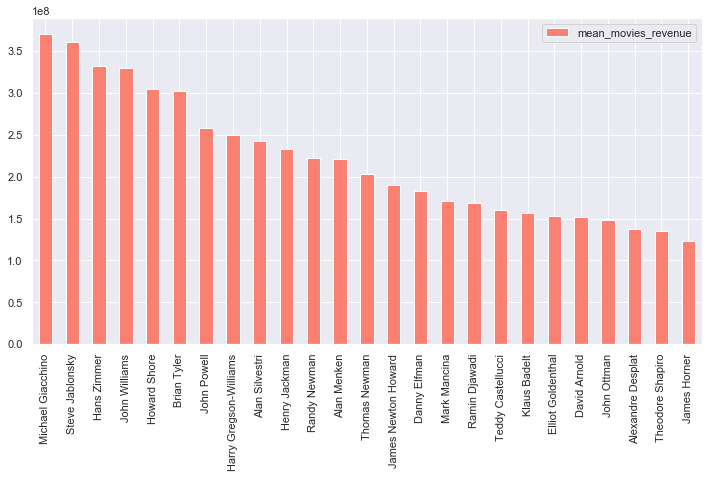

In [87]:
leadComposerDict = {}
for element in train[["revenue", "composers"]].values:
   # compare results when looking at x top composers in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadComposerDict:
            leadComposerDict[element[1][i]] = [element[0], 1]
        else:
            leadComposerDict[element[1][i]][0] += element[0]
            leadComposerDict[element[1][i]][1] += 1    

leadComposerDict = {k: v for k, v in leadComposerDict.items() if v[1] >= 5}

for composer in leadComposerDict:
    leadComposerDict[composer][0] = leadComposerDict[composer][0]/leadComposerDict[composer][1]
    leadComposerDict[composer] = leadComposerDict[composer][0]


    
    
composers_train = pd.DataFrame.from_dict(leadComposerDict, orient='index', columns=["mean_movies_revenue"])
composers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [88]:
# Sort both of our dicts
leadComposerDict = {k: v for k, v in sorted(leadComposerDict.items(), key=lambda item: item[1], reverse = True)}
composersDict = {k: v for k, v in sorted(composersDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top Composer'
def checkLeadComposer(crew):
    if len(crew) < 1 or crew[0] not in list(leadComposerDict)[:25]:
        return 0
    else:
        return 1

def checkTopComposers(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for composer in crew[:5]:
        if composer in list(composersDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD Composers
train['topLeadComposer'] = train['composers'].apply(lambda x: checkLeadComposer(x))
test['topLeadComposer'] = test['composers'].apply(lambda x: checkLeadComposer(x))

#Creating feature for number of top Composers
train['numTopComposers'] = train['composers'].apply(lambda x: checkTopComposers(x))
test['numTopComposers'] = test['composers'].apply(lambda x: checkTopComposers(x))


print(train['topLeadComposer'].value_counts())
print()
print(train['numTopComposers'].value_counts())

0    2666
1     334
Name: topLeadComposer, dtype: int64

0    2117
1     872
2      11
Name: numTopComposers, dtype: int64


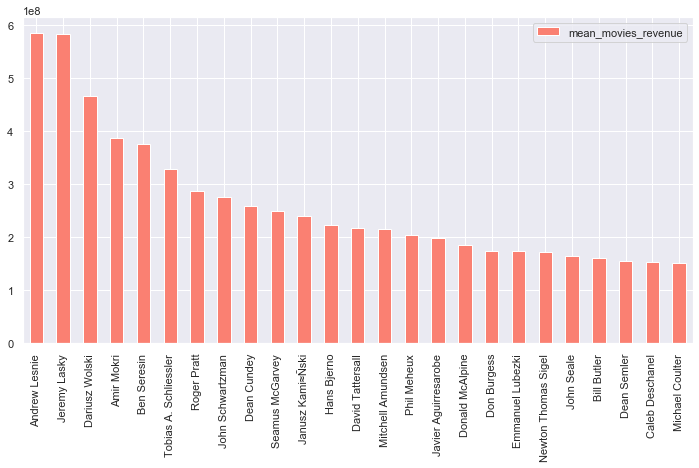

In [89]:
# bivariate director of photography
train['director_photos'] = train['crew'].apply(lambda x: re.findall("Director of Photography', 'name': '(.+?)'", x))

director_photosDict = {}
for element in train[["revenue", "director_photos"]].values:

    for director_photo in element[1]:
        if director_photo not in director_photosDict:
            director_photosDict[director_photo] = [element[0], 1]
        else:
            director_photosDict[director_photo][0] += element[0]
            director_photosDict[director_photo][1] += 1

director_photosDict = {k: v for k, v in director_photosDict.items() if v[1] >= 5}

for director_photo in director_photosDict:
    director_photosDict[director_photo][0] = director_photosDict[director_photo][0]/director_photosDict[director_photo][1]
    director_photosDict[director_photo] = director_photosDict[director_photo][0]




director_photos_train = pd.DataFrame.from_dict(director_photosDict, orient='index', columns=["mean_movies_revenue"])
director_photos_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

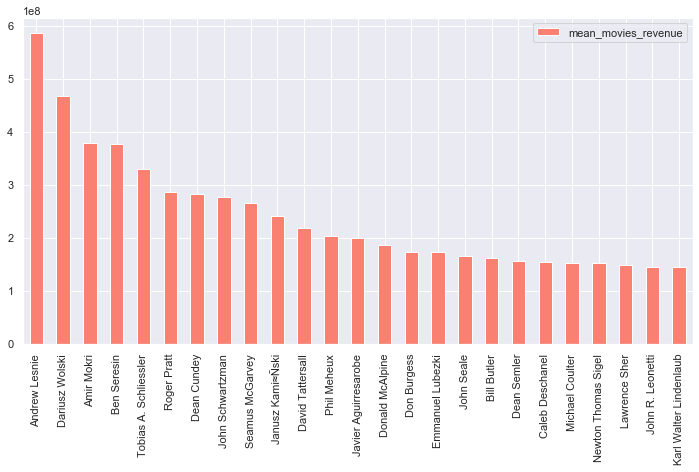

In [90]:
leadDirectorPhotoDict = {}
for element in train[["revenue", "director_photos"]].values:
   # compare results when looking at x top director_photos in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadDirectorPhotoDict:
            leadDirectorPhotoDict[element[1][i]] = [element[0], 1]
        else:
            leadDirectorPhotoDict[element[1][i]][0] += element[0]
            leadDirectorPhotoDict[element[1][i]][1] += 1    

leadDirectorPhotoDict = {k: v for k, v in leadDirectorPhotoDict.items() if v[1] >= 5}

for director_photo in leadDirectorPhotoDict:
    leadDirectorPhotoDict[director_photo][0] = leadDirectorPhotoDict[director_photo][0]/leadDirectorPhotoDict[director_photo][1]
    leadDirectorPhotoDict[director_photo] = leadDirectorPhotoDict[director_photo][0]


    
    
director_photos_train = pd.DataFrame.from_dict(leadDirectorPhotoDict, orient='index', columns=["mean_movies_revenue"])
director_photos_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [91]:
# Sort both of our dicts
leadDirectorPhotoDict = {k: v for k, v in sorted(leadDirectorPhotoDict.items(), key=lambda item: item[1], reverse = True)}
director_photosDict = {k: v for k, v in sorted(director_photosDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadDirectorPhoto(crew):
    if len(crew) < 1 or crew[0] not in list(leadDirectorPhotoDict)[:25]:
        return 0
    else:
        return 1

def checkTopDirectorsPhotos(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(director_photosDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD director of photography
train['topLeadDirectorPhoto'] = train['director_photos'].apply(lambda x: checkLeadDirectorPhoto(x))
test['topLeadDirectorPhoto'] = test['director_photos'].apply(lambda x: checkLeadDirectorPhoto(x))

#Creating feature for number of top director of photography
train['numTopDirectorsPhoto'] = train['director_photos'].apply(lambda x: checkTopDirectorsPhotos(x))
test['numTopDirectorsPhoto'] = test['director_photos'].apply(lambda x: checkTopDirectorsPhotos(x))


print(train['topLeadDirectorPhoto'].value_counts())
print()
print(train['numTopDirectorsPhoto'].value_counts())

0    2797
1     203
Name: topLeadDirectorPhoto, dtype: int64

0    2249
1     743
2       8
Name: numTopDirectorsPhoto, dtype: int64


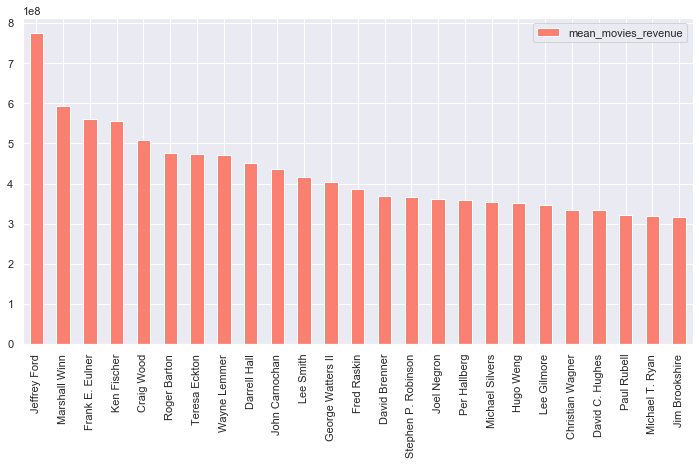

In [92]:
# bivariate editor
train['editors'] = train['crew'].apply(lambda x: re.findall("Editor', 'name': '(.+?)'", x))

editorsDict = {}
for element in train[["revenue", "editors"]].values:

    for editor in element[1]:
        if editor not in editorsDict:
            editorsDict[editor] = [element[0], 1]
        else:
            editorsDict[editor][0] += element[0]
            editorsDict[editor][1] += 1

editorsDict = {k: v for k, v in editorsDict.items() if v[1] >= 5}

for editor in editorsDict:
    editorsDict[editor][0] = editorsDict[editor][0]/editorsDict[editor][1]
    editorsDict[editor] = editorsDict[editor][0]




editors_train = pd.DataFrame.from_dict(editorsDict, orient='index', columns=["mean_movies_revenue"])
editors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

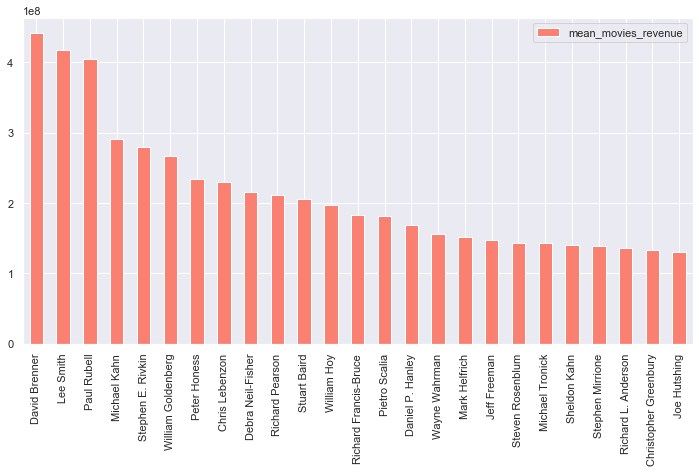

In [93]:
leadEditorDict = {}
for element in train[["revenue", "editors"]].values:
   # compare results when looking at x top editors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadEditorDict:
            leadEditorDict[element[1][i]] = [element[0], 1]
        else:
            leadEditorDict[element[1][i]][0] += element[0]
            leadEditorDict[element[1][i]][1] += 1    

leadEditorDict = {k: v for k, v in leadEditorDict.items() if v[1] >= 5}

for editor in leadEditorDict:
    leadEditorDict[editor][0] = leadEditorDict[editor][0]/leadEditorDict[editor][1]
    leadEditorDict[editor] = leadEditorDict[editor][0]


    
    
editors_train = pd.DataFrame.from_dict(leadEditorDict, orient='index', columns=["mean_movies_revenue"])
editors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [94]:
# Sort both of our dicts
leadEditorDict = {k: v for k, v in sorted(leadEditorDict.items(), key=lambda item: item[1], reverse = True)}
editorsDict = {k: v for k, v in sorted(editorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top Editor'
def checkLeadEditor(crew):
    if len(crew) < 1 or crew[0] not in list(leadEditorDict)[:25]:
        return 0
    else:
        return 1

def checkTopEditors(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for editor in crew[:5]:
        if editor in list(editorsDict)[:100]:
            count += 1
    return count

#Creating a feature for top LEAD Editors
train['topLeadEditor'] = train['editors'].apply(lambda x: checkLeadEditor(x))
test['topLeadEditor'] = test['editors'].apply(lambda x: checkLeadEditor(x))

#Creating feature for number of top Editors
train['numTopEditors'] = train['editors'].apply(lambda x: checkTopEditors(x))
test['numTopEditors'] = test['editors'].apply(lambda x: checkTopEditors(x))


print(train['topLeadEditor'].value_counts())
print()
print(train['numTopEditors'].value_counts())

0    2818
1     182
Name: topLeadEditor, dtype: int64

0    2663
1     222
2      74
3      32
4       9
Name: numTopEditors, dtype: int64
